In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import uhaf as uhaflib
uhaf = uhaflib.build_uhaf(latest=True)

In [5]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

/data/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)  
plt.rcParams['figure.dpi'] = 100        

# load data

In [40]:
adata_all = sc.read_h5ad("/data/hECA2.0/RNA/organ_organized/with_count_data/Pancreas.h5ad")

In [8]:
pd.crosstab(adata_all.obs.study_id,adata_all.obs.seq_tech)

seq_tech                        10X  Drop-Seq  inDrop  sciRNA-seq3  smartseq2
study_id                                                                     
10.1016/j.celrep.2019.02.043      0     16870       0            0          0
10.1016/j.cels.2016.08.011        0         0    8088            0          0
10.1101/2021.07.19.452956     12286         0       0            0        972
10.1126/science.aba7721           0         0       0        43155          0
10.1136/gutjnl-2021-324546     4855         0       0            0          0
10.1242/dev.200432             8369         0       0            0          0

We chose data from three different platform (Drop-seq, inDrop and sciRNA-seq3) as a demo for data integration across sequencing platform

In [41]:
adata_all = adata_all[adata_all.obs.study_id.isin(["10.1016/j.celrep.2019.02.043", "10.1016/j.cels.2016.08.011", "10.1126/science.aba7721"]),:]

In [42]:
adata_all.write_h5ad("/data/hECA2.0/RNA/ForVisual/Integration_demo.h5ad")

# visualization without integration

In [7]:
adata_all = sc.read_h5ad("/data/hECA2.0/RNA/ForVisual/Integration_demo.h5ad")

In [8]:
adata_all.obs.seq_tech.value_counts()

seq_tech
sciRNA-seq3    43155
Drop-Seq       16870
inDrop          8088
Name: count, dtype: int64

## preprocessing

In [9]:
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

In [10]:
sc.pp.highly_variable_genes(adata_all, batch_key="donor_ID", n_top_genes=2000,subset=True)

In [11]:
sc.pp.scale(adata_all, max_value=10)

## visualization

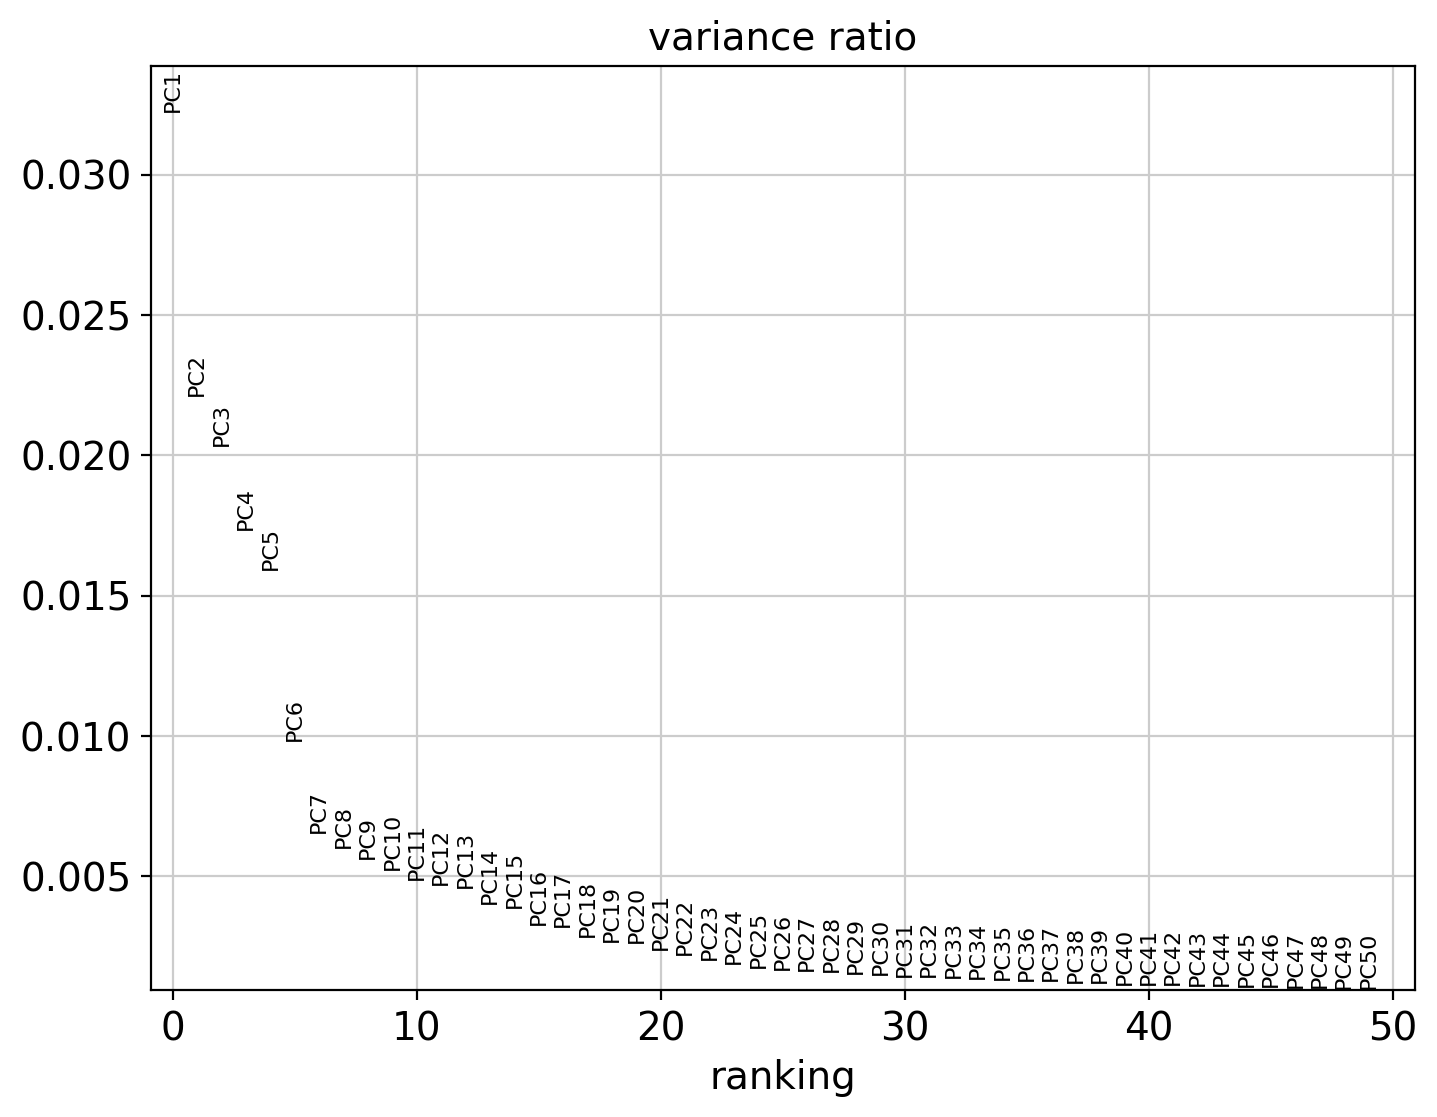

In [12]:
sc.pp.pca(adata_all)
sc.pl.pca_variance_ratio(adata_all, n_pcs=50)

In [13]:
sc.pp.neighbors(adata_all, n_neighbors=50, n_pcs=30)

In [14]:
sc.tl.umap(adata_all)

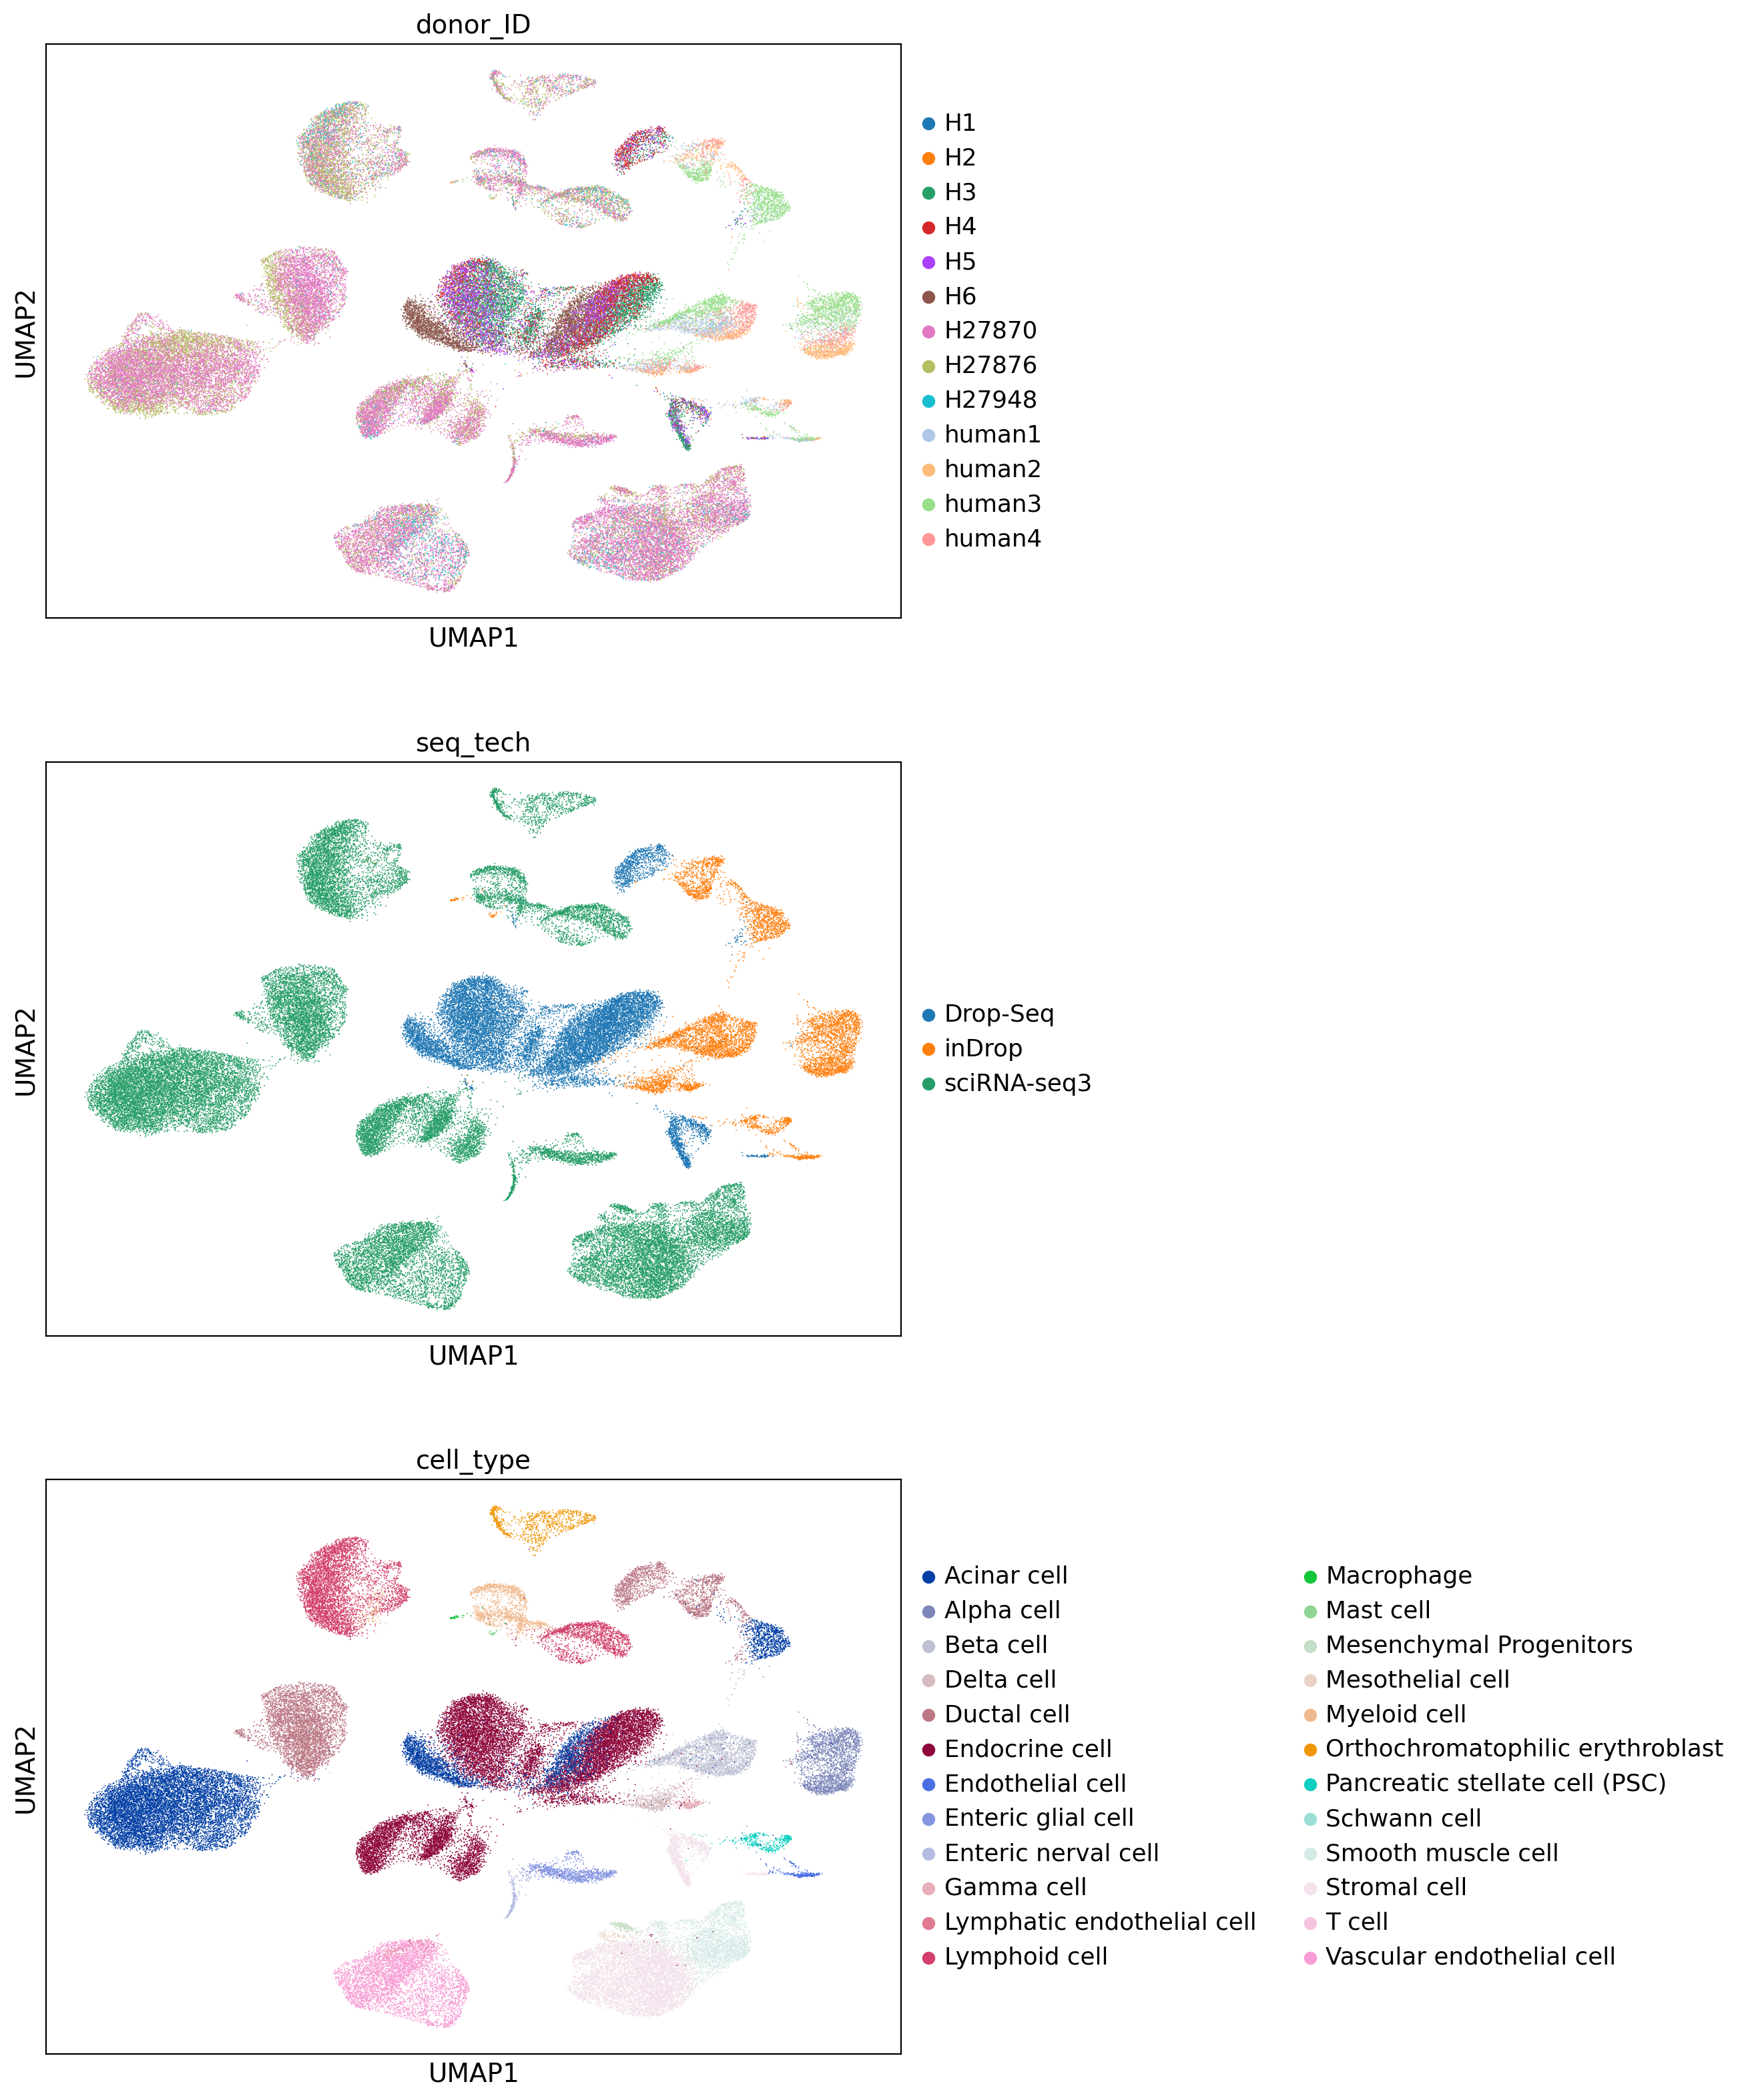

In [15]:
sc.pl.umap(adata_all, color=["donor_ID", "seq_tech", "cell_type"], ncols=1)

# Integration with scArches

In [17]:
adata_all = sc.read_h5ad("/data/hECA2.0/RNA/ForVisual/Integration_demo.h5ad")

In [18]:
adata_all.raw = adata_all  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_all,
    flavor="seurat_v3",
    n_top_genes=2000,
    batch_key="donor_ID",
    subset=True,
)

## mapping celltypes to the same annotation resolution

In [ ]:
coarse_mapping = {}
for ct in adata_all.obs.cell_type.unique():
    ancestors = uhaf.track_cell_from_uHAF(sheet_name="Pancreas", cell_type_target=ct)
    print(ancestors)
    coarse_mapping[ct] = ancestors[1]

In [21]:
adata_all.obs['coarse_cell_type'] = [coarse_mapping[ct] for ct in adata_all.obs.cell_type]

In [23]:
condition_key = 'donor_ID'
cell_type_key = 'coarse_cell_type'

## scVI

In [24]:
sca.models.SCVI.setup_anndata(adata_all, batch_key=condition_key, labels_key=cell_type_key)

In [25]:
vae = sca.models.SCVI(
    adata_all,
    n_layers=2,
    n_latent=30,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    gene_likelihood="nb"
)

In [26]:
vae.train(use_gpu=0, batch_size=512, max_epochs=200)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A800 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A800 80GB PCIe') that has Tensor Cores. To properly 

Epoch 200/200: 100%|██████████| 200/200 [09:18<00:00,  2.68s/it, v_num=1, train_loss_step=267, train_loss_epoch=257]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [09:18<00:00,  2.79s/it, v_num=1, train_loss_step=267, train_loss_epoch=257]


In [27]:
adata_all.obsm["X_scVI"] = vae.get_latent_representation()

In [28]:
sc.pp.neighbors(adata_all, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(adata_all)

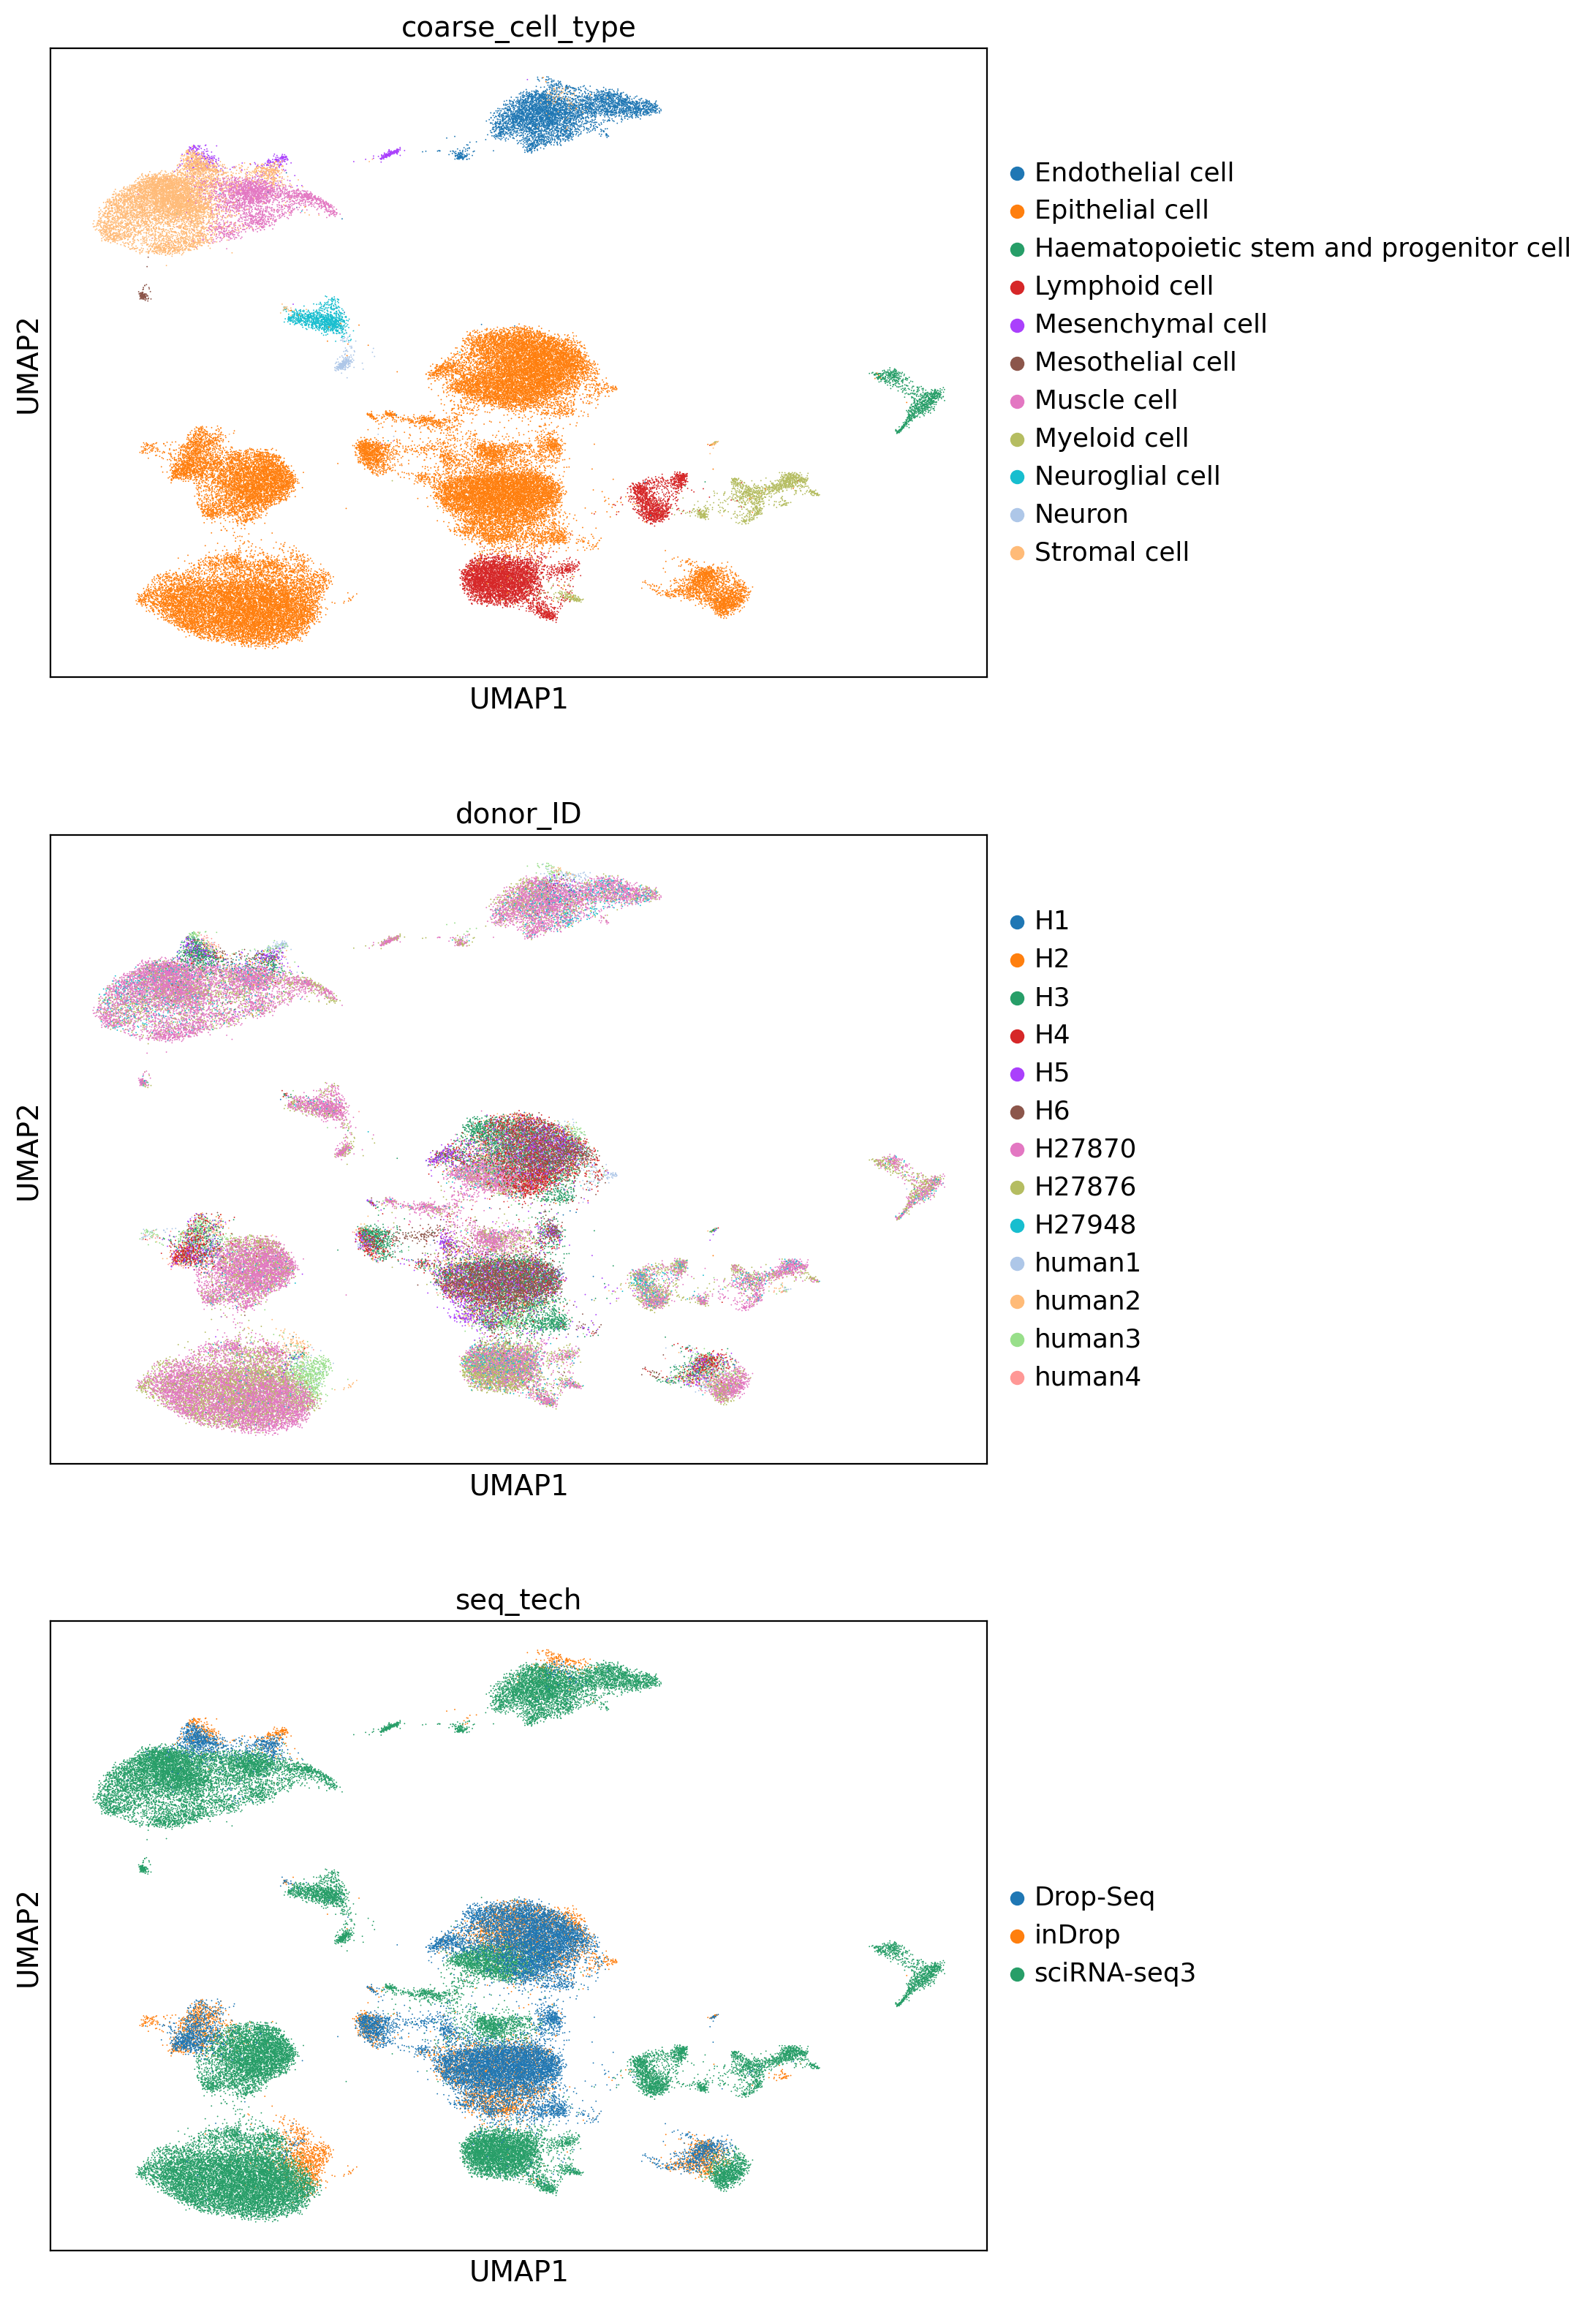

In [29]:
sc.pl.umap(adata_all, color=["coarse_cell_type", "donor_ID", "seq_tech"], ncols=1)

## scANVI

In [30]:
scanvi_model = sca.models.SCANVI.from_scvi_model(
    vae,
    adata=adata_all,
    labels_key="coarse_cell_type",
    unlabeled_category="Unclassified",
)

In [31]:
scanvi_model.train(max_epochs=50)

INFO     Training for 50 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 50/50: 100%|██████████| 50/50 [20:16<00:00, 24.29s/it, v_num=1, train_loss_step=327, train_loss_epoch=319]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [20:16<00:00, 24.33s/it, v_num=1, train_loss_step=327, train_loss_epoch=319]


In [32]:
adata_all.obsm["X_scANVI"] = scanvi_model.get_latent_representation()

In [33]:
sc.pp.neighbors(adata_all, use_rep="X_scANVI", n_neighbors=50)
sc.tl.umap(adata_all)

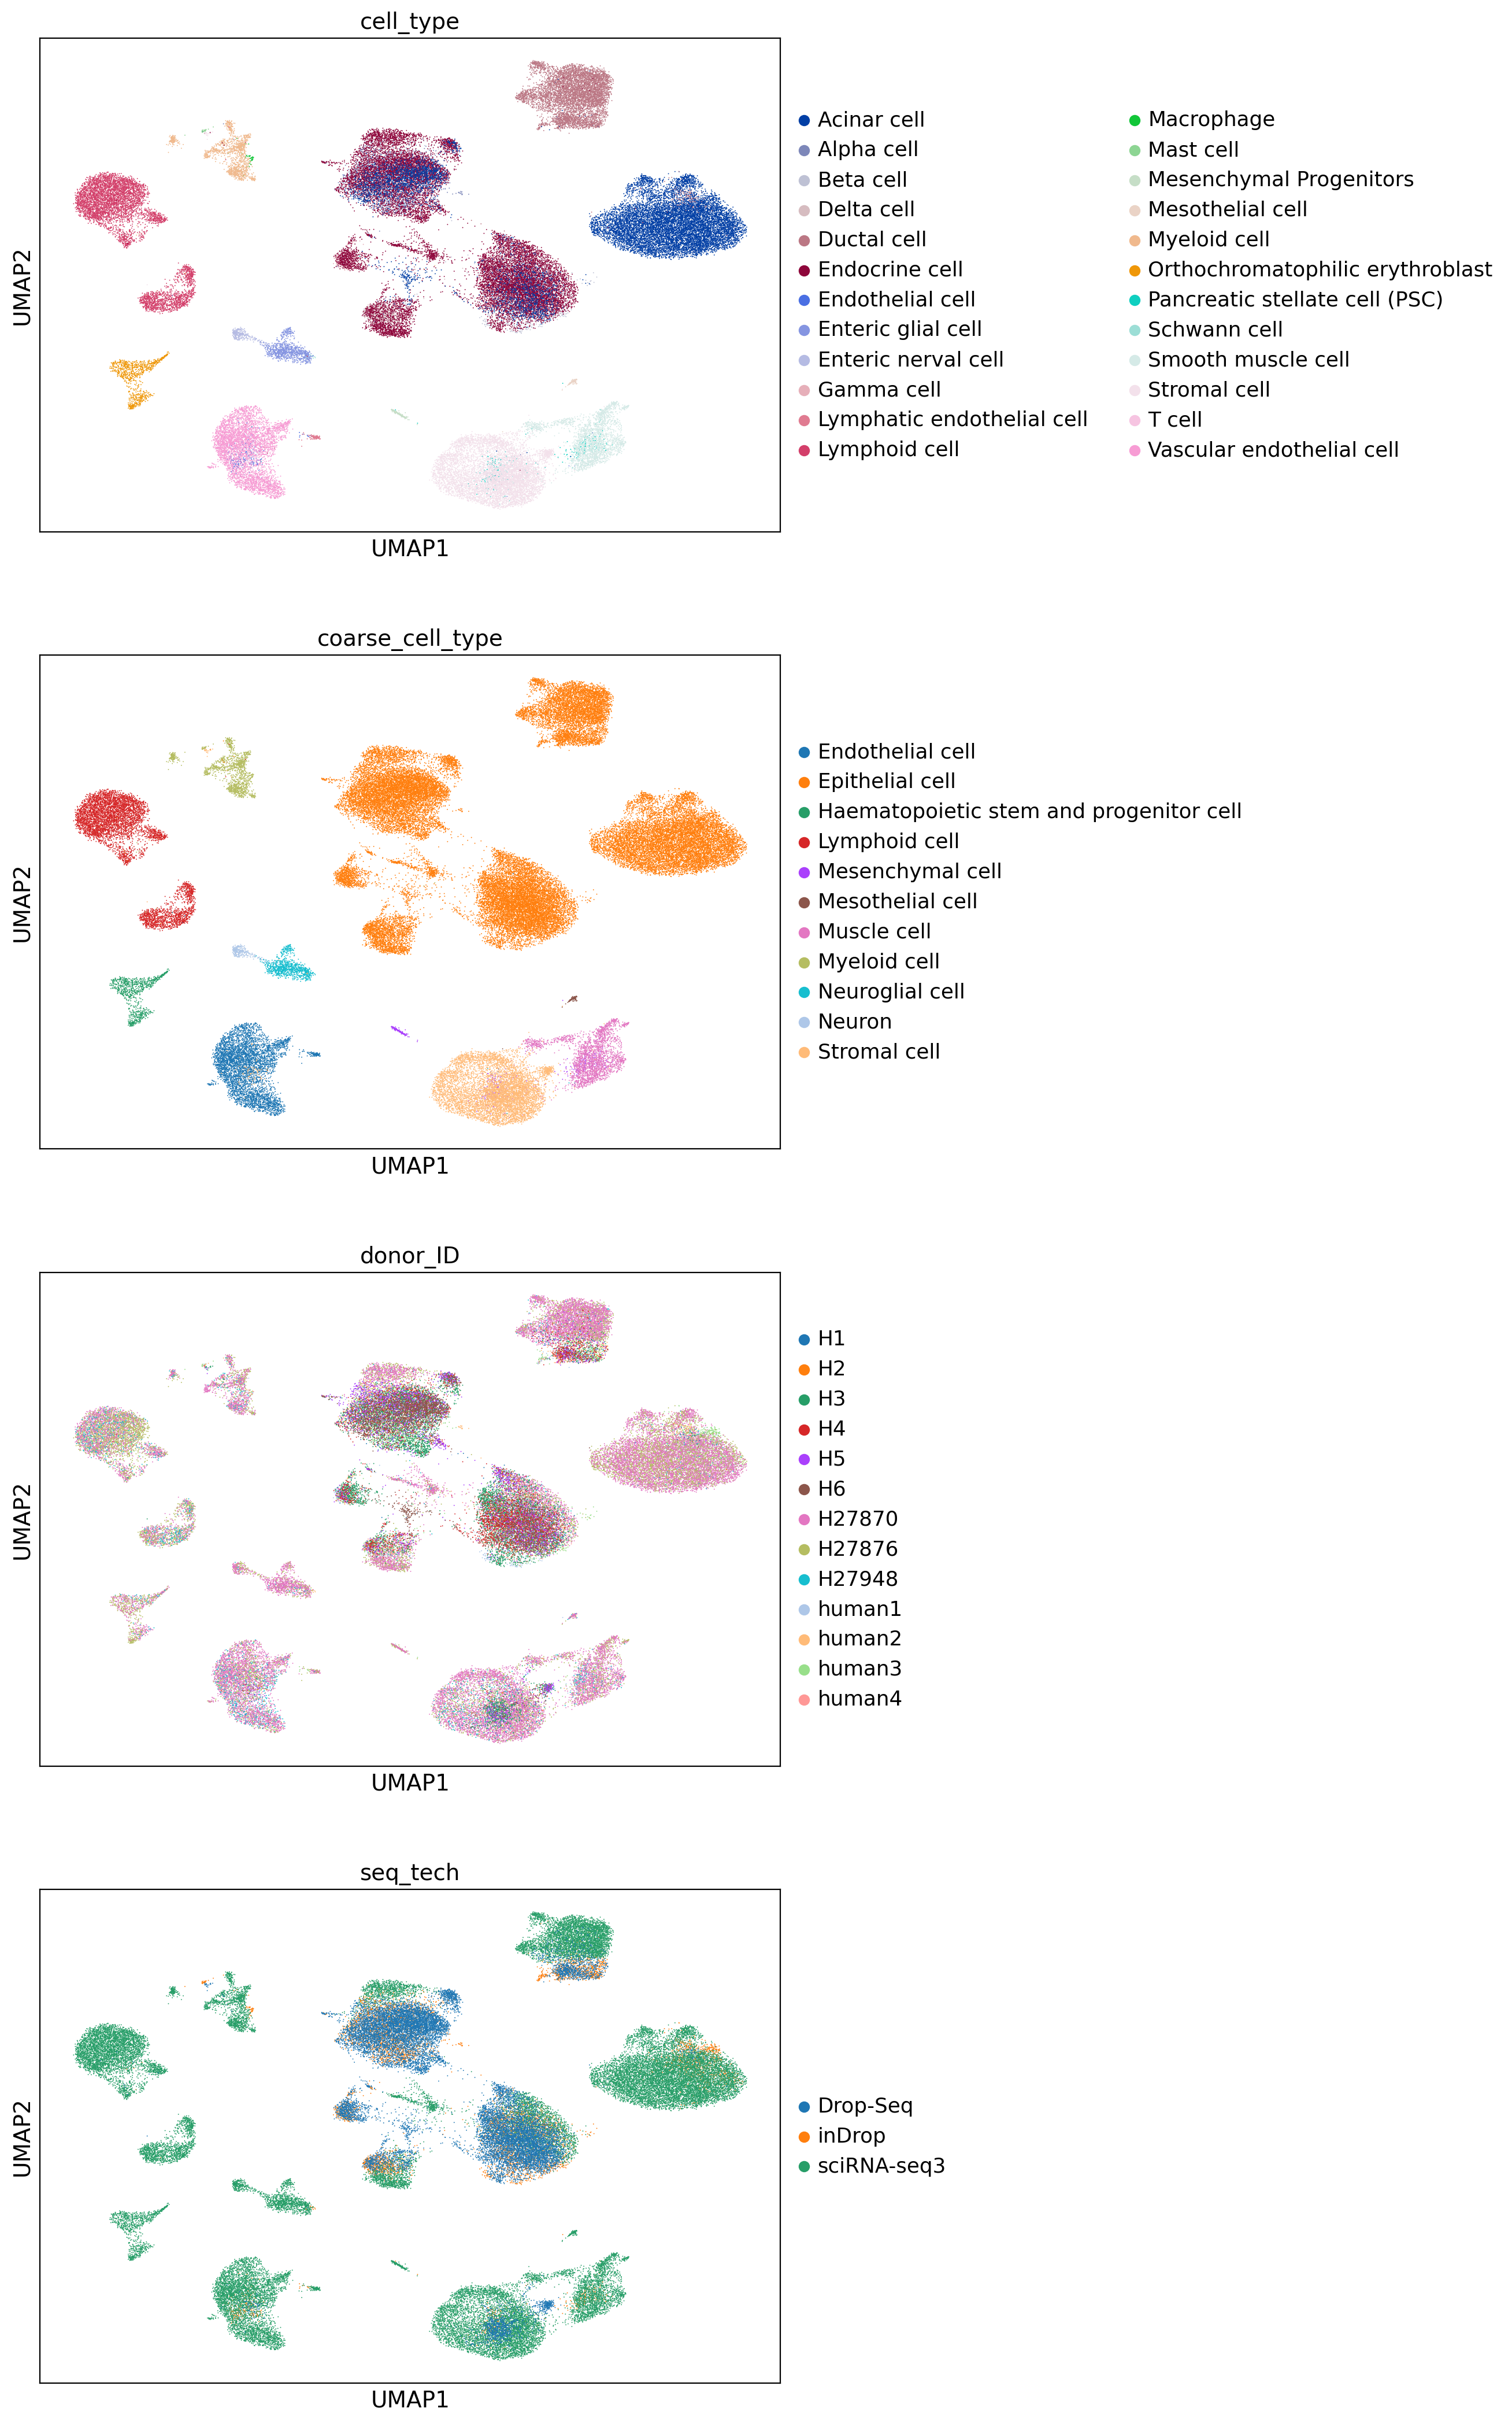

In [40]:
sc.pl.umap(adata_all, color=["cell_type", "coarse_cell_type", "donor_ID", "seq_tech"], ncols=1)

# benchmarking

In [35]:
from scib_metrics.benchmark import Benchmarker

In [36]:
adata_all

AnnData object with n_obs × n_vars = 68113 × 2000
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id', 'coarse_cell_type', '_scvi_batch', '_scvi_labels'
    var: 'Gene_symbol', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'coarse_cell_type_colors', 'donor_ID_colors', 'seq_tech_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    obsp: 'distances', 'connectivities'

In [ ]:
bm = Benchmarker(
    adata_all,
    batch_key="seq_tech",
    label_key="coarse_cell_type",
    embedding_obsm_keys=["X_pca", "X_scVI", 'X_scANVI'],
    n_jobs=-1,
)
bm.benchmark()

Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

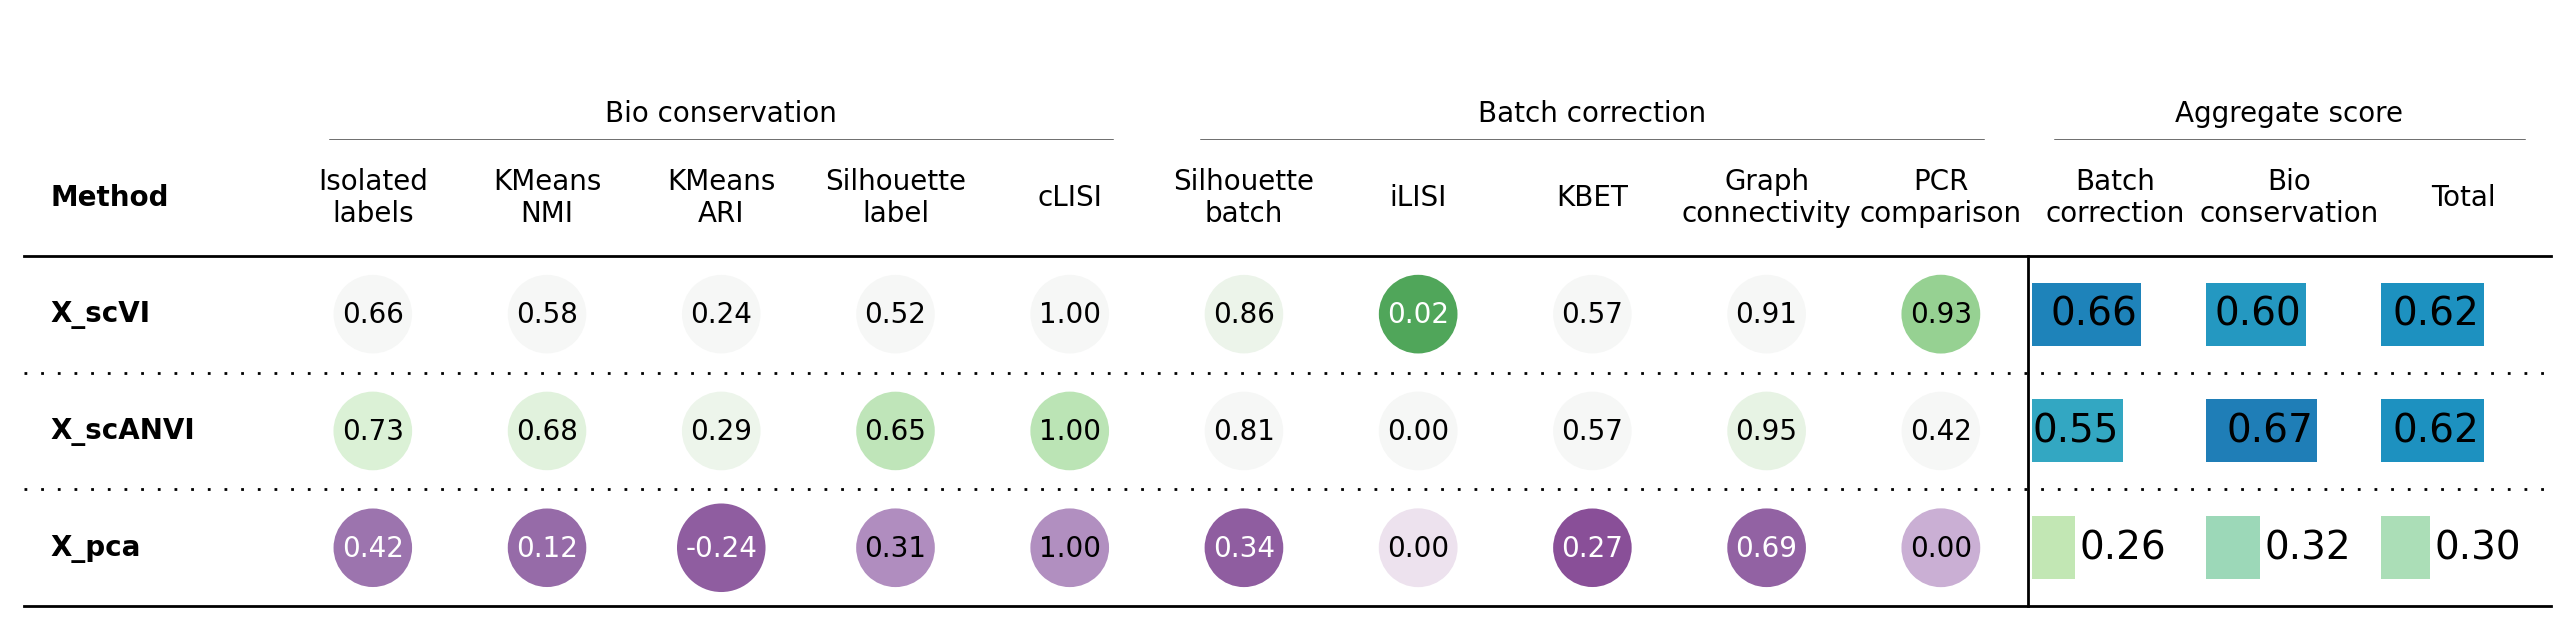

In [39]:
bm.plot_results_table(min_max_scale=False)